# Start

In [2]:
from google.colab import drive
import os
def check_path_and_mount(cloud_data_path):
  if os.getcwd() != "/content/cloud_data/My Drive/"+cloud_data_path:
    if not os.path.isdir("/content"):
      os.mkdir("/content");
    if not os.path.isdir("/content/cloud_data"):
      os.mkdir("/content/cloud_data");
    if not os.path.isdir("/content/cloud_data/My drive"):
      drive.mount("/content/cloud_data");
    if not os.path.isdir("/content/cloud_data/My Drive/"+cloud_data_path):
      return None;
    os.chdir("/content/cloud_data/My Drive/"+cloud_data_path);
  !ls -l
  !pwd
  return os.getcwd();

PWD = check_path_and_mount("titanic"); #資料夾cloud image的路徑

Drive already mounted at /content/cloud_data; to attempt to forcibly remount, call drive.mount("/content/cloud_data", force_remount=True).
total 1559
-rw------- 1 root root   3258 Dec 10  2019  gender_submission.csv
-rw------- 1 root root  28629 Dec 10  2019  test.csv
-rw------- 1 root root    316 Dec 22 02:13  titanic1.ipynb
-rw------- 1 root root 244243 Dec 25 13:15 'titanic (2).ipynb'
-rw------- 1 root root  64306 Dec 25 12:15  titanic.ipynb
-rw------- 1 root root 253729 Dec 31 11:43 'titanic predict 2.ipynb'
-rw------- 1 root root 599009 Jan  1 05:35 'titanic predict.ipynb'
-rw------- 1 root root  61194 Dec 10  2019  train.csv
-rw------- 1 root root 242808 Dec 26 13:41  期末報告.pdf
-rw------- 1 root root  96550 Dec 28 17:05  期末考.pdf
/content/cloud_data/.shortcut-targets-by-id/1R92r0WZBOEtXizkoCoJPC7b__fpCY6Z1/titanic


In [3]:
import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import keras

from collections import Counter
from threading import  Thread
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import gc
import regex
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_confusion_matrix, roc_curve, auc, plot_roc_curve, accuracy_score, log_loss
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [4]:
gender_submission_df = pd.read_csv(f'{PWD}/gender_submission.csv')
train_df = pd.read_csv(f'{PWD}/train.csv')
test_df = pd.read_csv(f'{PWD}/test.csv')


# Generate Data

In [5]:

class DataTransfer():
  def __init__(self, df = None, scalar_type = "minmax", encoding_type = "onehot", n_components=None):
    self.scalar_type = scalar_type;
    self.encoding_type = encoding_type;
    self.n_components = n_components;
    if df is not None:
      self.fit(df, scalar_type = scalar_type, encoding_type = encoding_type, n_components = n_components)
  def _todict(self, ary):
    return dict([(k,i) for i,k in enumerate(ary)])
  def fit(self, df, scalar_type =None, encoding_type = None, n_components=None):
    if scalar_type is not None: self.scalar_type = scalar_type;
    if encoding_type is not None: self.encoding_type = encoding_type;
    if n_components is not None: self.n_components = n_components;
    self.df = None;
    self.ticket_types = None
    self.name_types = None
    self.embarked_types = None
    self.labelencoders = None
    self.standard_scalar = None
    self.minmax_scalar = None
    self.standard_scalars = None
    self.pca = None;
    self.most_vals = None
    self.df = df.copy(True);
    self.fit_ticket()
    self.fit_name()
    tmp_df = self.transform_name(self.transform_ticket(df.copy(True)));
    self.fit_nan(tmp_df)
    tmp_df = self.transform_nan(tmp_df, way="drop");
    self.fit_label_encoding(tmp_df)
    self.fit_onehot_encoding(tmp_df)
    tmp_df = self.transform_onehot_encoding(tmp_df) if self.encoding_type == "onehot" else self.transform_label_encoding(tmp_df);
    self.fit_standard_scalar(tmp_df)
    self.fit_minmax_scalar(tmp_df)
    tmp_df = self.transform_minmax_scalar(tmp_df) if self.scalar_type == "minmax" else self.transform_standard_scalar(tmp_df);
    self.fit_pca(tmp_df, self.n_components)
    return self
  def transform(self, df, way = "replace"):
    df = self.transform_nan(self.transform_name(self.transform_ticket(df)), way);
    df = self.transform_onehot_encoding(df) if self.encoding_type == "onehot" else self.transform_label_encoding(df);
    df = self.transform_minmax_scalar(df) if self.scalar_type == "minmax" else self.transform_standard_scalar(df);
    return df
  def fit_ticket(self, df=None):
    if df is None: df = self.df;
    ticket_type = pd.Series(np.zeros((len(df)), dtype="object"),dtype="object", name="Ticket")
    for i,e in enumerate(df["Ticket"].dropna()):
      tmp = e.split(" ")
      ticket_type[i] = tmp[0] if len(tmp)>1 else "None"
    self.ticket_types = ticket_type.unique()
    return self.ticket_types
  def fit_name(self, df=None):
    if df is None: df = self.df;
    name_type = pd.Series(np.zeros((len(df)), dtype="object"),dtype="object", name="Name")
    for i,e in enumerate(df["Name"].dropna()):
      tmp = regex.findall(", .*\\.",e)[0][2:-1]
      tmp2 = regex.findall(".*\\.",tmp);
      name_type[i] = tmp2[0][:-1] if len(tmp2) != 0 else tmp
    self.name_types = name_type.unique()
    return self.name_types
  def fit_nan(self, df=None):
    if df is None: df = self.df;
    self.most_vals = {};
    for key in df.columns.drop(["PassengerId","Survived"]):
      if df[key].dtype.name[:5] == "float": 
        self.most_vals[key] = df[key].median()
      else: 
        self.most_vals[key] = df[key].mode()[0]
      #self.most_vals[key] = df[key].median() if df[key].dtype[:5] == "float" else df[key].mode()[0];
    return self.most_vals
  def fit_label_encoding(self, df=None):
    if df is None: df = self.df;
    self.labelencoders = {"Name":LabelEncoder(), "Ticket":LabelEncoder(), "Embarked":LabelEncoder(), "Sex":LabelEncoder()};
    for key,encoder in self.labelencoders.items():
      encoder.fit(df[key].dropna())
    return self.labelencoders
  def fit_onehot_encoding(self, df=None):
    if df is None: df = self.df;
    self.embarked_types = df["Embarked"].dropna().unique();
    return self.embarked_types
  def fit_standard_scalar(self, df=None):
    if df is None: df = self.df;
    '''
    key_list = ["Pclass", "Age", "SibSp", "Parch",	"Fare",	"Ticket_Num"];
    if self.encoding_type == "label": key_list += ["Name", "Embarked", "Ticket"]
    '''
    self.standard_scalars = {}
    for key in df.columns.drop("Survived"):
      self.standard_scalars[key] = StandardScaler().fit(df[[key]].dropna())
    return self.standard_scalars
  def fit_minmax_scalar(self, df=None):
    if df is None: df = self.df;
    self.minmax_scalar = MinMaxScaler().fit(df.dropna())
    return self.minmax_scalar
  def transform_ticket(self, df=None):
    if df is None: df = self.df;
    ticket_type = pd.Series(np.zeros((len(df)), dtype="object"),dtype="object", name="Ticket")
    ticket_price = pd.Series(np.zeros((len(df)), dtype="float32"),dtype="float32", name="Ticket_Num")
    for i,e in enumerate(df["Ticket"]):
      tmp = e.split(" ")
      tmp2 = tmp[0] if len(tmp)>1 else "None"
      ticket_type[i] = tmp2 if tmp2 in self.ticket_types else self.most_vals["Ticket"];
      ticket_price[i] = float(tmp[-1]) if tmp[-1].isnumeric() else 0.;
    df["Ticket"] = ticket_type;
    df["Ticket_Num"] = ticket_price;
    return df
  def transform_name(self, df=None):
    if df is None: df = self.df;
    name_type = pd.Series(np.zeros((len(df)), dtype="object"),dtype="object", name="Name")
    for i,e in enumerate(df["Name"]):
      tmp = regex.findall(", .*\\.",e)[0][2:-1]
      tmp2 = regex.findall(".*\\.",tmp);
      tmp = tmp2[0][:-1] if len(tmp2) != 0 else tmp
      name_type[i] = tmp if tmp in self.name_types else self.most_vals["Name"];
    df["Name"] = name_type;
    return df
  def transform_nan(self, df=None, way = "replace"):
    if df is None: df = self.df;
    df = df.drop(["Cabin", "PassengerId"], axis=1)
    if way == "drop":
      df = df.dropna()
    elif way == "replace":
      for key in df.columns.drop(["Survived"]):
        df[key] =  df[key].fillna(self.most_vals[key])
    return df
  def transform_label_encoding(self, df=None):
    if df is None: df = self.df;
    for key,encoder in self.labelencoders.items():
      df[key] = encoder.transform(df[key])
    return df
  def transform_onehot_encoding(self, df=None):
    if df is None: df = self.df;
    for key in self.ticket_types:
      df["Ticket_"+key] = (df["Ticket"]==key).astype("float32")
    for key in self.name_types:
      df["Name_"+key] = (df["Name"]==key).astype("float32")
    for key in self.embarked_types:
      df["Embarked_"+key] = (df["Embarked"]==key).astype("float32")
    df["Sex"] = (df["Sex"]=="female").astype("float32")
    df = df.drop(["Name", "Ticket", "Embarked"], axis=1);
    return df;
  def transform_standard_scalar(self, df=None):
    if df is None: df = self.df;
    for key,encoder in self.standard_scalars.items():
      df[key] = encoder.transform(df[[key]].dropna())
    return df
  def transform_minmax_scalar(self, df=None):
    if df is None: df = self.df;
    df.loc[:,:] = self.minmax_scalar.transform(df)
    return df
  # x_train,y_train
  def fit_pca(self, df=None, n_components = None):
    if n_components is None: return;
    if df is None: df = self.df;
    self.pca = PCA(n_components=n_components)
    self.pca.fit(df.drop("Survived", axis=1))
    return self.pca
  def transform_pca(self, df=None):
    if df is None: df = self.df;
    if self.pca is None: return df;
    return self.pca.transform(df)
  def transform_train_test_data(self, df=None):
    if df is None: df = self.df;
    x_train, x_test = train_test_split(df, train_size = 0.8)
    y_train, y_test = x_train[["Survived"]], x_test[["Survived"]]
    x_train, x_test = x_train.drop("Survived", axis=1), x_test.drop("Survived", axis=1)
    if self.pca is not None: x_train, x_test = self.pca.transform(x_train), self.pca.transform(x_test)
    return x_train, y_train, x_test, y_test;
  def transform_features(self, df=None, pca = True):
    if df is None: df = self.df;
    df = df.drop(["Survived"], axis=1)
    if self.pca is None: return df;
    else: return self.pca.transform(df);
  def transform_labels(self, df=None):
    if df is None: df = self.df;
    return df[["Survived"]];

### Generate train data

In [6]:

data_fit1 = DataTransfer(encoding_type="onehot", scalar_type="standard", n_components=50).fit(train_df)
train_df1 = data_fit1.transform(train_df.copy(True), "drop")

data_fit2 = DataTransfer(encoding_type="onehot", scalar_type="minmax", n_components=50).fit(train_df)
train_df2 = data_fit2.transform(train_df.copy(True), "drop")

data_fit3 = DataTransfer(encoding_type="label", scalar_type="standard", n_components=8).fit(train_df)
train_df3 = data_fit3.transform(train_df.copy(True), "drop")

data_fit4 = DataTransfer(encoding_type="label", scalar_type="minmax", n_components=8).fit(train_df)
train_df4 = data_fit4.transform(train_df.copy(True), "drop")

data_fits = [data_fit1, data_fit2, data_fit3, data_fit4]
train_dfs = [train_df1, train_df2, train_df3, train_df4]
title_list = ["One Hot Encoding & Standardize", "One Hot Encoding &  Normalize", "Label Encoding & Standardize", "Label Encoding & Normalize"]

### Generate testing data

In [7]:

test_df.insert(loc=0, column='Survived', value=gender_submission_df["Survived"])


test_df1 = data_fit1.transform(test_df.copy(True))

test_df2 = data_fit2.transform(test_df.copy(True))

test_df3 = data_fit3.transform(test_df.copy(True))

test_df4 = data_fit4.transform(test_df.copy(True))

test_dfs = [test_df1, test_df2, test_df3, test_df4]


### Train test split

##### Using generate validation data in train data

In [151]:
train_test_data_list = [trans.transform_train_test_data(df) for trans,df in zip(data_fits, train_dfs)]

##### Or take test data as validation data

In [147]:
train_test_data_list = [(trans.transform_features(trdf),trans.transform_labels(trdf),trans.transform_features(tedf),trans.transform_labels(tedf)) for trans,trdf,tedf in zip(data_fits, train_dfs, test_dfs)]

### Set Other with few feature

In [ ]:

ticket4show = demo_train_df["Ticket"].copy(True)
name4show = demo_train_df["Name"].copy(True)

counter = Counter(ticket4show)
most = counter.most_common(4)
ticket4show[(ticket4show!=most[0][0]) & (ticket4show!=most[1][0]) & (ticket4show!=most[2][0]) & (ticket4show!=most[3][0])] = "Other"

counter = Counter(name4show)
most = counter.most_common(4)
name4show[(name4show!=most[0][0]) & (name4show!=most[1][0]) & (name4show!=most[2][0]) & (name4show!=most[3][0])] = "Other"



# Exploratory Data Analysis (EDA)

##### Replace Value for NaN

In [11]:
data_fit1.most_vals

{'Age': 28.0,
 'Cabin': 'B96 B98',
 'Embarked': 'S',
 'Fare': 14.4542,
 'Name': 'Mr',
 'Parch': 0,
 'Pclass': 3,
 'Sex': 'male',
 'SibSp': 0,
 'Ticket': 'None',
 'Ticket_Num': 112058.0}

#####  Correlation

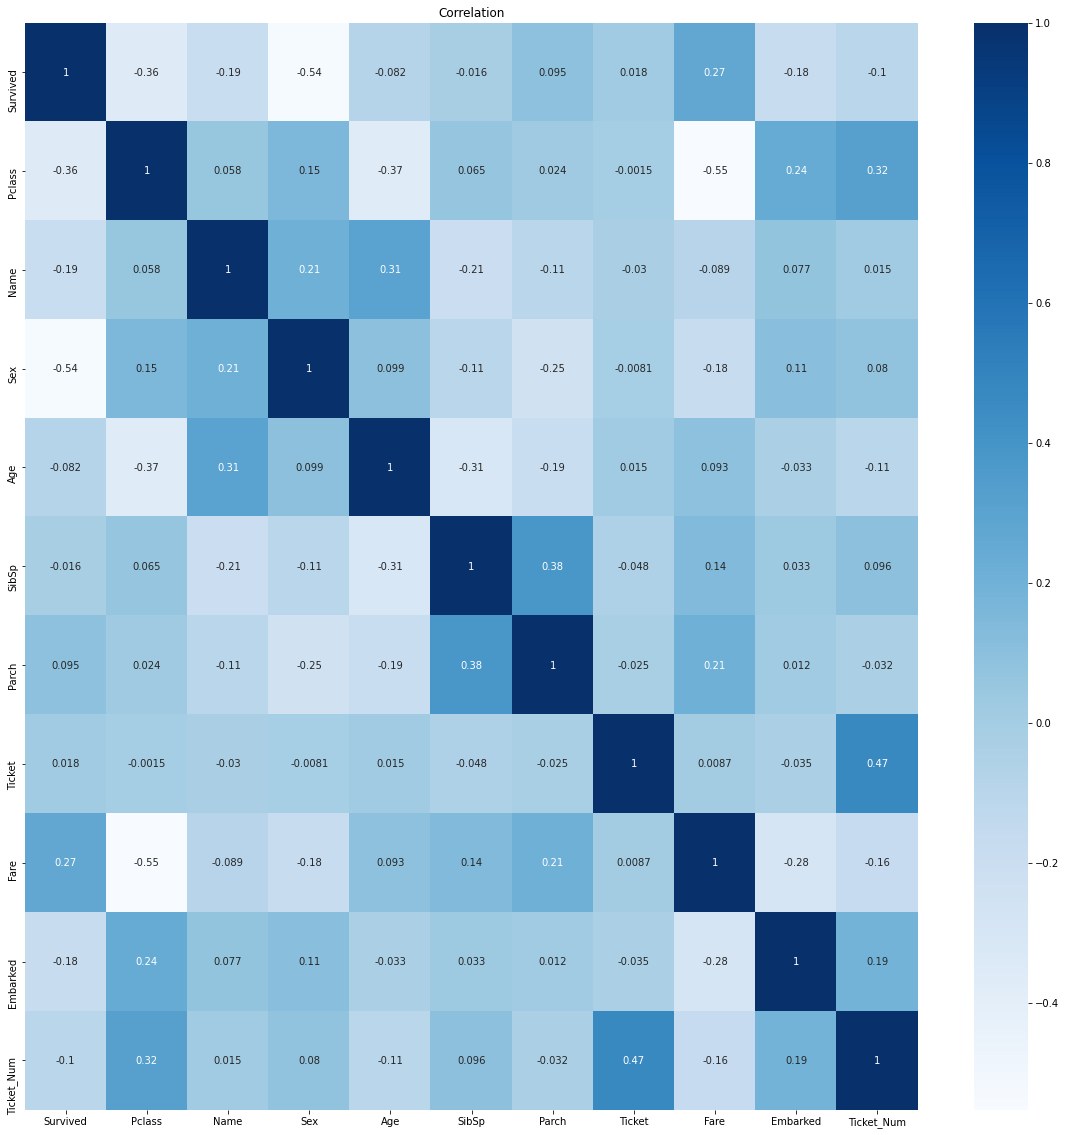

In [130]:
fig = plt.figure(figsize=(20,20))

plt.title("Correlation")
sns.heatmap(train_df3.corr(),annot=True, cmap="Blues")


##### Show Data

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

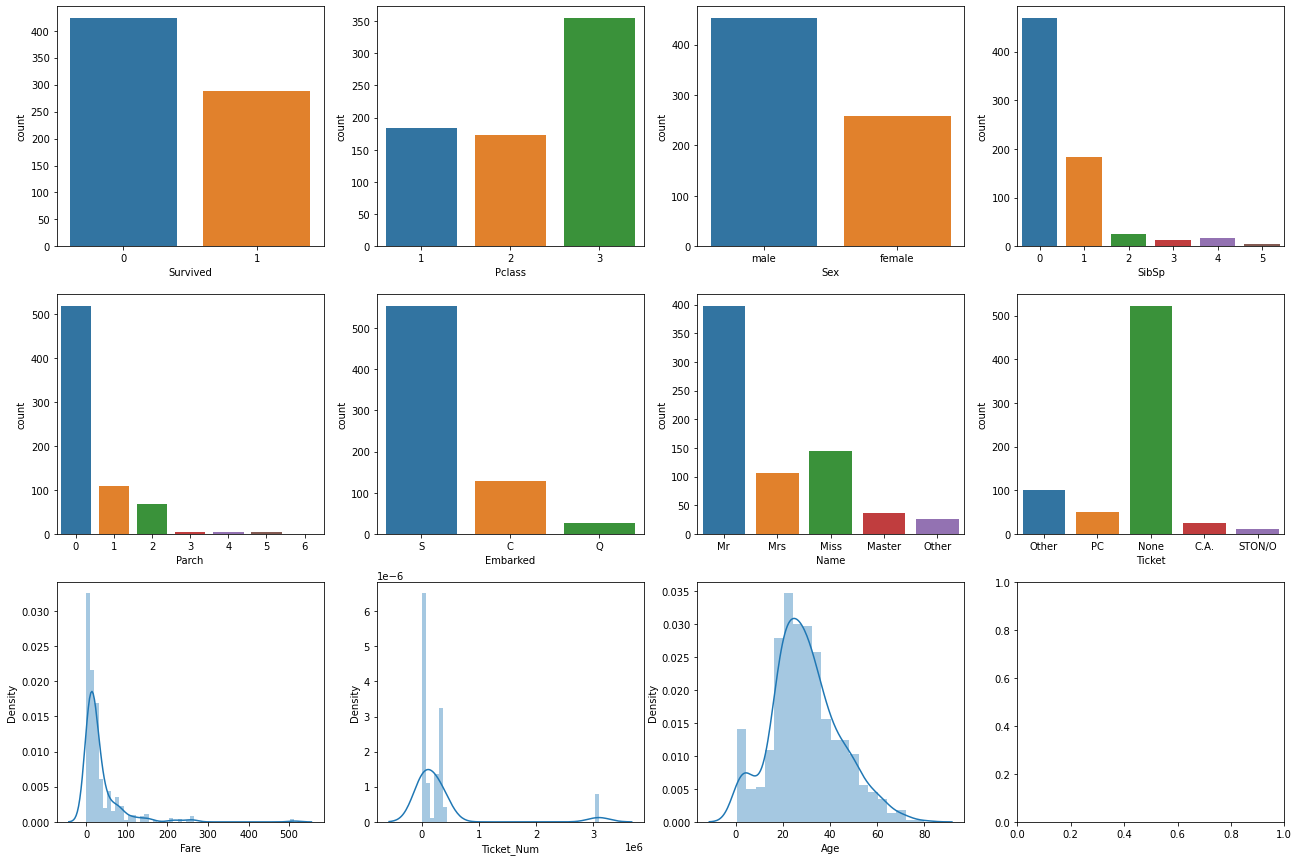

In [137]:

fig,ax = plt.subplots(3,4,figsize=(22,15))
sns.countplot('Survived',data=demo_train_df,ax=ax[0][0])
sns.countplot('Pclass',data=demo_train_df,ax=ax[0][1])
sns.countplot('Sex',data=demo_train_df,ax=ax[0][2])
sns.countplot('SibSp',data=demo_train_df,ax=ax[0][3])
sns.countplot('Parch',data=demo_train_df,ax=ax[1][0])
sns.countplot('Embarked',data=demo_train_df,ax=ax[1][1])
sns.countplot(name4show,ax=ax[1][2])
sns.countplot(ticket4show,ax=ax[1][3])
sns.distplot(demo_train_df['Fare'],kde=True,ax=ax[2][0])
sns.distplot(demo_train_df['Ticket_Num'],kde=True,ax=ax[2][1])
sns.distplot(demo_train_df['Age'],kde=True,ax=ax[2][2])


#### Compare Data

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

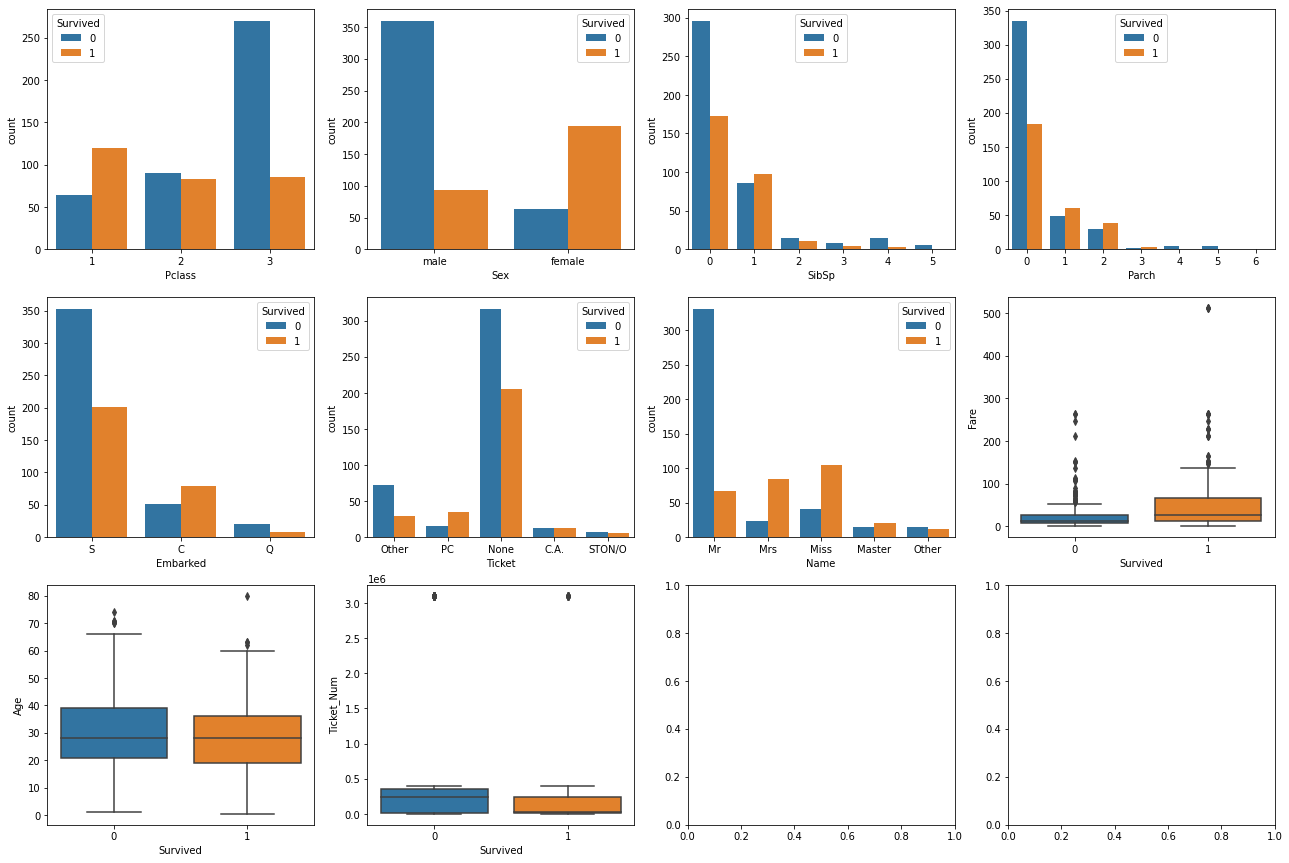

In [141]:

fig,ax = plt.subplots(3,4,figsize=(22,15))
sns.countplot(demo_train_df["Pclass"], hue = demo_train_df['Survived'],ax=ax[0][0])
sns.countplot(demo_train_df["Sex"], hue = demo_train_df['Survived'],ax=ax[0][1])
sns.countplot(demo_train_df["SibSp"], hue = demo_train_df['Survived'],ax=ax[0][2])
sns.countplot(demo_train_df["Parch"], hue = demo_train_df['Survived'],ax=ax[0][3])
sns.countplot(demo_train_df["Embarked"], hue = demo_train_df['Survived'],ax=ax[1][0])
sns.countplot(ticket4show, hue = demo_train_df['Survived'],ax=ax[1][1])
sns.countplot(name4show, hue = demo_train_df['Survived'],ax=ax[1][2])
sns.boxplot(x="Survived", y="Fare", data=demo_train_df, ax = ax[1][3])
sns.boxplot(x="Survived", y="Age", data=demo_train_df, ax = ax[2][0])
sns.boxplot(x="Survived", y="Ticket_Num", data=demo_train_df, ax = ax[2][1])

### eigen values and eigen vectors

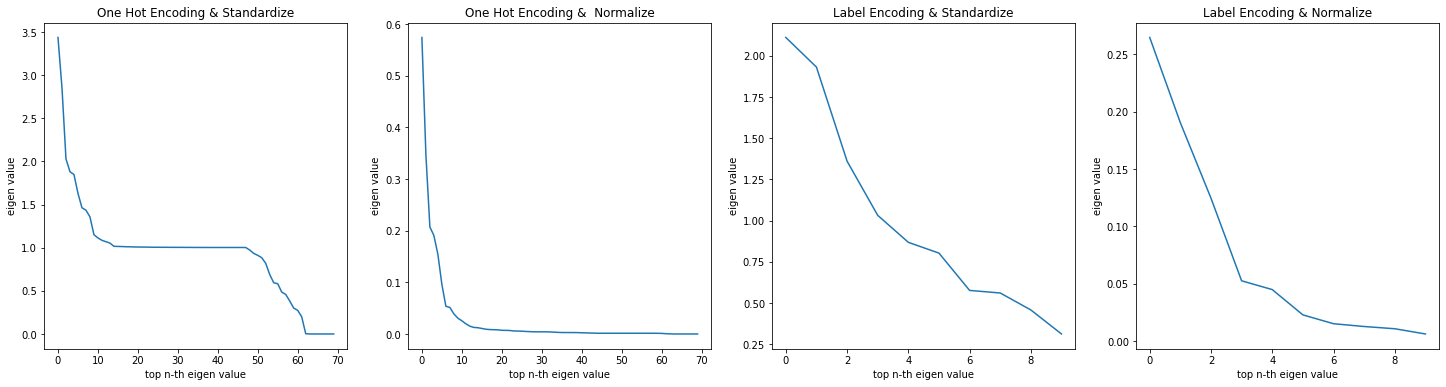

In [ ]:

def get_cov_eigen_pair(df):
  cov_mat = np.cov(df.drop("Survived",axis=1).T)
  return np.linalg.eig(cov_mat)

fig = plt.figure(figsize=(25, 6));

for i,df in enumerate(train_dfs):
  ax = fig.add_subplot(1, 4, i+1);
  ax.set_title(title_list[i])
  ax.set_xlabel("top n-th eigen value")
  ax.set_ylabel("eigen value")
  eigen_vals, eigen_vecs = get_cov_eigen_pair(df)
  plt.plot(eigen_vals[np.flip(eigen_vals.argsort())])


#  Interpretation  Data Preprocessing

##### Original data

In [46]:
demo_train_df = train_df.copy(True)
demo_train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


##### Solve Ticket and Name

In [47]:
demo_train_df = data_fit1.transform_name(data_fit1.transform_ticket(train_df.copy(True)))
demo_train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_Num
0,1,0,3,Mr,male,22.0,1,0,A/5,7.2500,NaN,S,21171.0
1,2,1,1,Mrs,female,38.0,1,0,PC,71.2833,C85,C,17599.0
2,3,1,3,Miss,female,26.0,0,0,STON/O2.,7.9250,NaN,S,3101282.0
3,4,1,1,Mrs,female,35.0,1,0,None,53.1000,C123,S,113803.0
4,5,0,3,Mr,male,35.0,0,0,None,8.0500,NaN,S,373450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,Rev,male,27.0,0,0,None,13.0000,NaN,S,211536.0
887,888,1,1,Miss,female,19.0,0,0,None,30.0000,B42,S,112053.0
888,889,0,3,Miss,female,NaN,1,2,W./C.,23.4500,NaN,S,6607.0
889,890,1,1,Mr,male,26.0,0,0,None,30.0000,C148,C,111369.0


##### Dealing with NaN (drop nan data)

In [48]:
demo_train_df = data_fit1.transform_nan(demo_train_df, way="drop")
demo_train_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Ticket_Num
0,0,3,Mr,male,22.0,1,0,A/5,7.2500,S,21171.0
1,1,1,Mrs,female,38.0,1,0,PC,71.2833,C,17599.0
2,1,3,Miss,female,26.0,0,0,STON/O2.,7.9250,S,3101282.0
3,1,1,Mrs,female,35.0,1,0,None,53.1000,S,113803.0
4,0,3,Mr,male,35.0,0,0,None,8.0500,S,373450.0
...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,Mrs,female,39.0,0,5,None,29.1250,Q,382652.0
886,0,2,Rev,male,27.0,0,0,None,13.0000,S,211536.0
887,1,1,Miss,female,19.0,0,0,None,30.0000,S,112053.0
889,1,1,Mr,male,26.0,0,0,None,30.0000,C,111369.0


##### Label Encoding

In [49]:
demo_train_df1 = data_fit3.transform_label_encoding(demo_train_df.copy(True))
demo_train_df1

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Ticket_Num
0,0,3,11,1,22.0,1,0,4,7.2500,2,21171.0
1,1,1,12,0,38.0,1,0,15,71.2833,0,17599.0
2,1,3,8,0,26.0,0,0,33,7.9250,2,3101282.0
3,1,1,12,0,35.0,1,0,13,53.1000,2,113803.0
4,0,3,11,1,35.0,0,0,13,8.0500,2,373450.0
...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,12,0,39.0,0,5,13,29.1250,1,382652.0
886,0,2,14,1,27.0,0,0,13,13.0000,2,211536.0
887,1,1,8,0,19.0,0,0,13,30.0000,2,112053.0
889,1,1,11,1,26.0,0,0,13,30.0000,0,111369.0


##### One Hot Encoding

In [ ]:
demo_train_df2 = data_fit1.transform_onehot_encoding(demo_train_df.copy(True))
demo_train_df2

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Ticket_Num,Ticket_A/5,Ticket_PC,Ticket_STON/O2.,Ticket_None,Ticket_PP,Ticket_A/5.,Ticket_C.A.,Ticket_A./5.,Ticket_SC/Paris,Ticket_S.C./A.4.,Ticket_A/4.,Ticket_CA,Ticket_S.P.,Ticket_S.O.C.,Ticket_SO/C,Ticket_W./C.,Ticket_SOTON/OQ,Ticket_W.E.P.,Ticket_STON/O,Ticket_A4.,Ticket_C,Ticket_SOTON/O.Q.,Ticket_SC/PARIS,Ticket_S.O.P.,Ticket_A.5.,Ticket_Fa,Ticket_CA.,Ticket_F.C.C.,Ticket_W/C,Ticket_SW/PP,Ticket_SCO/W,Ticket_P/PP,Ticket_SC,Ticket_SC/AH,Ticket_A/S,Ticket_A/4,Ticket_WE/P,Ticket_S.W./PP,Ticket_S.O./P.P.,Ticket_F.C.,Ticket_SOTON/O2,Ticket_S.C./PARIS,Ticket_C.A./SOTON,Name_Mr,Name_Mrs,Name_Miss,Name_Master,Name_Don,Name_Rev,Name_Dr,Name_Mme,Name_Ms,Name_Major,Name_Lady,Name_Sir,Name_Mlle,Name_Col,Name_Capt,Name_the Countess,Name_Jonkheer,Embarked_S,Embarked_C,Embarked_Q
0,0,3,0.0,22.0,1,0,7.2500,21171.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1,1,1.0,38.0,1,0,71.2833,17599.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,3,1.0,26.0,0,0,7.9250,3101282.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,1,1.0,35.0,1,0,53.1000,113803.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,3,0.0,35.0,0,0,8.0500,373450.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,1.0,39.0,0,5,29.1250,382652.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
886,0,2,0.0,27.0,0,0,13.0000,211536.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
887,1,1,1.0,19.0,0,0,30.0000,112053.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
889,1,1,0.0,26.0,0,0,30.0000,111369.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


##### Standardize

In [ ]:
demo_train_df3 = data_fit3.transform_standard_scalar(demo_train_df1.copy(True))
demo_train_df3

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Ticket_Num
0,0,0.908600,0.412591,0.756138,-0.527669,0.522511,-0.506787,-1.824949,-0.516380,0.519588,-0.420568
1,1,-1.482983,0.938110,-1.322511,0.577094,0.522511,-0.506787,0.187299,0.694046,-2.049487,-0.425591
2,1,0.908600,-1.163965,-1.322511,-0.251478,-0.552714,-0.506787,3.480070,-0.503620,0.519588,3.911466
3,1,-1.482983,0.938110,-1.322511,0.369951,0.522511,-0.506787,-0.178564,0.350326,0.519588,-0.290285
4,0,0.908600,0.412591,0.756138,0.369951,-0.552714,-0.506787,-0.178564,-0.501257,0.519588,0.074897
...,...,...,...,...,...,...,...,...,...,...,...
885,0,0.908600,0.938110,-1.322511,0.646142,-0.552714,5.350885,-0.178564,-0.102875,-0.764949,0.087839
886,0,-0.287191,1.989148,0.756138,-0.182430,-0.552714,-0.506787,-0.178564,-0.407687,0.519588,-0.152828
887,1,-1.482983,-1.163965,-1.322511,-0.734812,-0.552714,-0.506787,-0.178564,-0.086335,0.519588,-0.292746
889,1,-1.482983,0.412591,0.756138,-0.251478,-0.552714,-0.506787,-0.178564,-0.086335,-2.049487,-0.293708


##### Normalize

In [ ]:
demo_train_df4 = data_fit4.transform_minmax_scalar(demo_train_df1.copy(True))
demo_train_df4

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Ticket_Num
0,0.0,1.0,0.6875,1.0,0.271174,0.2,0.000000,0.105263,0.014151,1.0,0.006826
1,1.0,0.0,0.7500,0.0,0.472229,0.2,0.000000,0.394737,0.139136,0.0,0.005675
2,1.0,1.0,0.5000,0.0,0.321438,0.0,0.000000,0.868421,0.015469,1.0,0.999989
3,1.0,0.0,0.7500,0.0,0.434531,0.2,0.000000,0.342105,0.103644,1.0,0.036695
4,0.0,1.0,0.6875,1.0,0.434531,0.0,0.000000,0.342105,0.015713,1.0,0.120417
...,...,...,...,...,...,...,...,...,...,...,...
885,0.0,1.0,0.7500,0.0,0.484795,0.0,0.833333,0.342105,0.056848,0.5,0.123384
886,0.0,0.5,0.8750,1.0,0.334004,0.0,0.000000,0.342105,0.025374,1.0,0.068208
887,1.0,0.0,0.5000,0.0,0.233476,0.0,0.000000,0.342105,0.058556,1.0,0.036131
889,1.0,0.0,0.6875,1.0,0.321438,0.0,0.000000,0.342105,0.058556,0.0,0.035910


##### Apply PCA

In [ ]:
demo_train_pca_df = data_fit3.transform_features(demo_train_df3)
pd.DataFrame(demo_train_pca_df, columns=["PC-"+str(i+1) for i in range(demo_train_pca_df.shape[1])])

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8
0,-0.906875,-0.048395,-2.118395,0.167563,0.673821,0.168063,-0.701709,0.074298
1,2.297174,-0.598337,0.822974,-0.202056,0.100652,-1.323700,-1.294626,-0.559001
2,-2.606537,1.312346,4.500821,-0.978546,-1.506117,0.207963,-0.246563,-0.075457
3,1.185433,-0.425851,0.119374,0.779570,-0.986068,0.261405,-1.379682,0.104126
4,-1.242945,-0.902389,-0.433088,0.086959,0.087378,0.044652,0.152687,0.029075
...,...,...,...,...,...,...,...,...
707,0.891665,1.942203,-0.220693,2.621029,-1.444431,-3.096909,2.885258,-0.427131
708,-0.753108,-1.489125,-0.446850,0.867498,0.268811,-0.446268,-0.394857,0.893509
709,0.984901,0.363279,-0.024631,-1.177751,-1.367607,1.067337,-0.302427,0.518563
710,1.201571,-1.163322,0.220704,-0.988418,1.310969,-0.795260,0.013041,0.004778


In [ ]:
demo_train_pca_df = data_fit1.transform_features(train_df1)
pd.DataFrame(demo_train_pca_df, columns=["PC-"+str(i+1) for i in range(demo_train_pca_df.shape[1])])

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,PC-11,PC-12,PC-13,PC-14,PC-15,PC-16,PC-17,PC-18,PC-19,PC-20,PC-21,PC-22,PC-23,PC-24,PC-25,PC-26,PC-27,PC-28,PC-29,PC-30,PC-31,PC-32,PC-33,PC-34,PC-35,PC-36,PC-37,PC-38,PC-39,PC-40,PC-41,PC-42,PC-43,PC-44,PC-45,PC-46,PC-47,PC-48,PC-49,PC-50
0,-2.120015,-0.574894,1.159663,0.694283,0.436327,-0.745988,-2.618994,0.768073,0.468524,0.424609,-0.793126,-0.677832,0.469131,2.344038,-0.728087,1.653403,0.130700,-3.914313,6.451135,-0.030979,-0.129641,-0.646624,1.051616,-1.199470,-0.285212,0.025057,-0.845052,0.076422,0.064740,0.099546,0.024628,0.073729,-0.005213,0.080309,-0.424480,0.247659,0.227303,0.030082,-0.000124,5.979429e-13,2.300583e-13,6.459678e-13,3.334756e-14,-2.110266e-13,4.187305e-13,-0.008334,-0.009789,0.204654,-0.295082,-1.658007
1,4.361160,-2.070017,0.742550,1.102291,-0.212929,-1.094009,0.774400,-0.158953,1.095265,0.494021,0.209109,-0.580681,0.297754,0.138243,-0.043231,0.018936,0.018897,-0.033687,-0.031503,-0.009133,-0.034386,-0.018471,-0.024179,-0.008244,-0.021426,-0.021329,0.001453,-0.010777,-0.012805,0.003862,0.004713,0.029424,-0.035345,-0.032289,-0.002585,-0.021155,-0.036364,0.008807,0.000512,2.878543e-13,-2.626971e-13,-8.883725e-14,8.771424e-13,1.017176e-12,-9.197109e-14,0.001313,0.003182,-0.129350,-0.365452,-0.507893
2,-0.524410,2.539240,0.506313,5.179695,-4.961590,1.140376,1.645649,0.134565,-1.179768,0.562639,0.167307,1.924839,2.037411,1.116698,-1.315418,1.132063,3.267263,-2.034254,0.154659,-3.242747,0.400393,2.956522,1.492591,1.847360,-0.249984,-1.041712,0.567026,0.706659,-2.745158,-0.473226,-0.056929,-0.709710,-0.122173,0.040501,0.244968,-0.352979,0.020422,0.170109,-0.042153,-2.628576e-11,1.777202e-11,-1.298100e-12,-7.200192e-11,-7.470771e-11,8.065210e-13,-0.018722,-0.006560,-0.112942,-0.636579,1.062656
3,1.429787,0.721612,-1.907836,0.277838,0.557881,-1.118458,0.968214,-0.578118,0.653993,0.037910,0.219790,-0.195104,0.499422,-0.096580,0.010211,0.010022,0.004140,-0.011784,-0.008104,-0.011002,-0.022987,-0.014081,-0.009224,-0.007987,-0.022541,-0.021784,-0.000221,-0.009269,-0.012783,0.003531,0.004137,0.025176,-0.038038,-0.027886,-0.005112,-0.018579,-0.039069,0.008822,0.000522,2.971891e-13,-2.767255e-13,-9.921218e-14,8.883095e-13,1.060257e-12,-9.795693e-14,0.001513,0.002616,-0.133494,-0.352906,0.074862
4,-1.813365,-0.449745,-0.463631,-0.508551,-0.008560,0.162811,-0.027733,-0.236543,-0.023006,-0.160691,-0.019570,-0.269176,-0.056953,0.174414,-0.079976,0.015786,0.000260,0.010603,-0.029538,-0.022398,-0.034003,-0.008260,-0.025007,0.004511,-0.017144,-0.023317,0.015853,-0.017507,-0.012725,-0.000472,0.002250,0.013189,-0.032005,-0.029460,0.001516,-0.027070,-0.043653,0.009790,0.000633,3.502452e-13,-3.611736e-13,-1.016911e-13,1.083494e-12,1.309653e-12,-1.461961e-13,0.002248,0.000995,-0.145138,-0.062107,0.282144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,2.277228,2.440138,-0.449969,-1.221657,-0.006664,0.675230,1.353558,0.271835,3.429243,2.188013,-1.119174,-0.371578,-1.827187,-1.146952,-0.013398,0.077333,0.002538,0.015688,0.070831,0.027406,-0.043871,0.043119,-0.004998,-0.000799,-0.009193,-0.054957,0.008031,-0.028376,-0.024936,0.009828,0.001447,0.000341,-0.036691,-0.027369,-0.003429,-0.040968,-0.046748,0.027543,0.001182,7.184949e-13,-7.058406e-13,-7.623841e-14,2.052476e-12,2.402325e-12,-2.496902e-13,0.003173,0.000618,-0.245701,0.832666,-1.703962
708,-0.808852,-0.154669,-1.707962,-0.799405,0.542344,0.107228,2.607737,6.987298,-0.880708,-0.983637,0.280940,-0.643540,0.219235,-0.116472,-0.022574,-0.061057,0.008372,0.009179,-0.002213,-0.023577,-0.033326,-0.016981,-0.010375,-0.006247,-0.034358,-0.029440,0.009241,-0.016901,-0.013988,-0.000340,0.001206,0.014646,-0.040819,-0.029510,-0.005817,-0.026268,-0.040068,0.009442,0.000585,3.636260e-13,-2.951136e-13,-8.599185e-14,1.000347e-12,1.153045e-12,-9.219938e-14,0.001002,0.002202,-0.146032

# Modeling And Result

### function definition

In [142]:
def get_roc_auc(model, X, y):
  probs = model.predict(X)
  preds = probs.reshape(len(probs))
  fpr, tpr, threshold = roc_curve(y, preds)
  roc_auc = auc(fpr, tpr)
  return fpr, tpr, roc_auc
def get_confusion_matrix(model, X, y, threshold=0.5):
  y_pred = model.predict(X) > threshold
  df_cm = pd.DataFrame(confusion_matrix(y, y_pred), index = [0,1],
                  columns = [0,1])
  return df_cm

### Keras

##### Training models

In [143]:


def fit_model(data_fit, df, train_test_data):
  x_train, y_train, x_test, y_test = train_test_data
  input_size = x_train.shape[1]

  earlystopping = EarlyStopping(monitor='val_loss', mode='min', 
                patience=5,     restore_best_weights=True,
                verbose=0)

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min',
                patience=3,     factor=0.5,
                min_lr=1e-6,    verbose=0)

  inputs = layers.Input(input_size)
  dense1 = layers.Dense(32)(inputs)
  dense2 = layers.Dense(32)(dense1)
  dense3 = layers.Dense(16)(dense2)
  dense4 = layers.Dense(1, activation = 'sigmoid')(dense3)

  model = models.Model(inputs = inputs, outputs = dense4)

  model.compile(optimizer = keras.optimizers.Adam(lr = 1e-3), loss = 'binary_crossentropy'
    , metrics = ['accuracy'])
  
  
  train_history = model.fit(x_train, y_train,
          batch_size=1000,
          epochs=32,
          verbose=0,
          validation_data=(x_test, y_test)
          , callbacks=[earlystopping, reduce_lr])
  return model, train_history


In [152]:
model_list = []
histories = []

def run_keras_models():
  for trans, df, data in zip(data_fits, train_dfs, train_test_data_list):
    model, history = fit_model(trans, df, data)
    model_list.append(model)
    histories.append(history)

Thread(target = run_keras_models).start();

#### Validation data

##### ROC for validation data

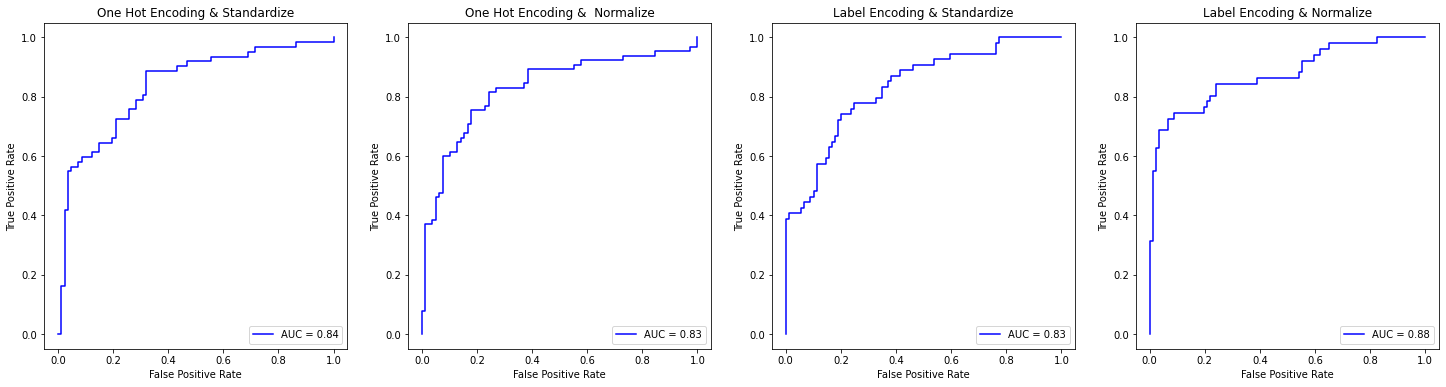

In [154]:

fig = plt.figure(figsize=(25, 6));

for i,model in enumerate(model_list):
  ax = fig.add_subplot(1, 4, i+1);
  ax.set_title(title_list[i])
  ax.set_xlabel("False Positive Rate")
  ax.set_ylabel("True Positive Rate")
  fpr, tpr, roc_auc = get_roc_auc(model, train_test_data_list[i][2], train_test_data_list[i][3])
  ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  ax.legend(loc = 'lower right')


##### Confusion matrix for validation data

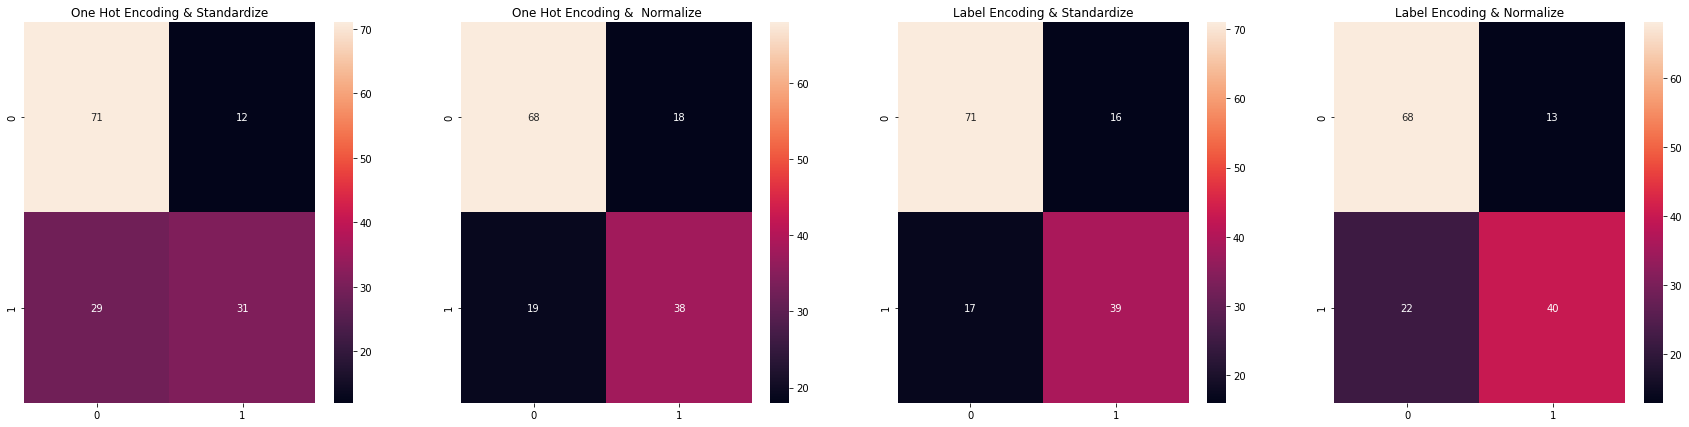

In [ ]:

fig = plt.figure(figsize = (30,7))


for i,model in enumerate(model_list):
  ax = fig.add_subplot(1, 4, i+1);
  ax.set_title(title_list[i])
  sns.heatmap(get_confusion_matrix(model, train_test_data_list[i][2], train_test_data_list[i][3]), annot=True, ax=ax)



##### Accuracy

One Hot Encoding & Standardize: 0.748251736164093
One Hot Encoding &  Normalize : 0.7832167744636536
Label Encoding & Standardize  : 0.7762237787246704
Label Encoding & Normalize    : 0.8251748085021973


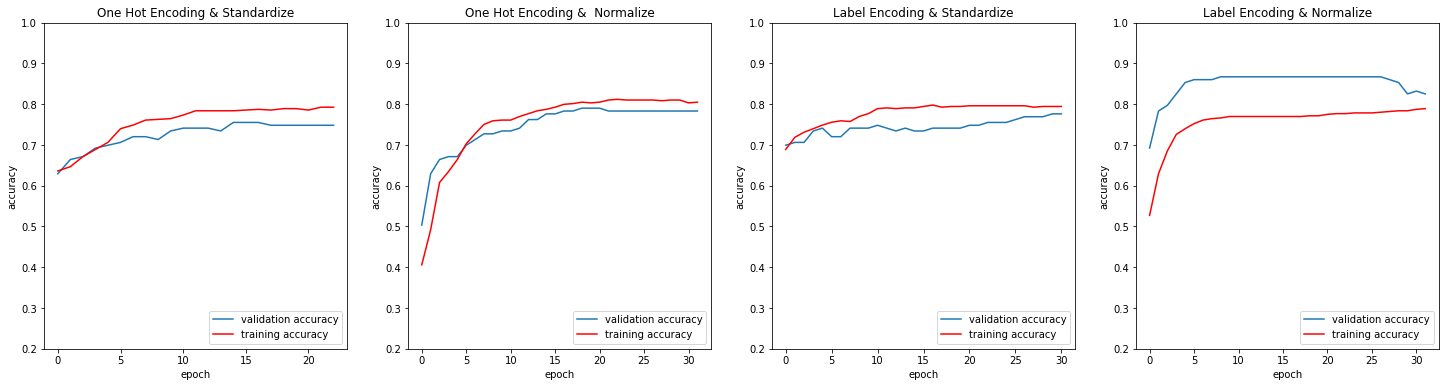

In [155]:

fig = plt.figure(figsize=(25, 6));
for i,history in enumerate(histories):
  ax = fig.add_subplot(1, 4, i+1);
  ax.set_ylim((0.2,1.))
  ax.set_title(title_list[i])
  ax.set_xlabel("epoch")
  ax.set_ylabel("accuracy")
  ax.plot(history.history["val_accuracy"], label = "validation accuracy")
  ax.plot(history.history["accuracy"], color="red", label = "training accuracy")
  ax.legend(loc = 'lower right')
  print("{:<30}: {}".format(title_list[i], history.history["val_accuracy"][-1]))


##### Loss

One Hot Encoding & Standardize: 0.6055381894111633
One Hot Encoding &  Normalize : 0.51154625415802
Label Encoding & Standardize  : 0.4716164171695709
Label Encoding & Normalize    : 0.5310449004173279


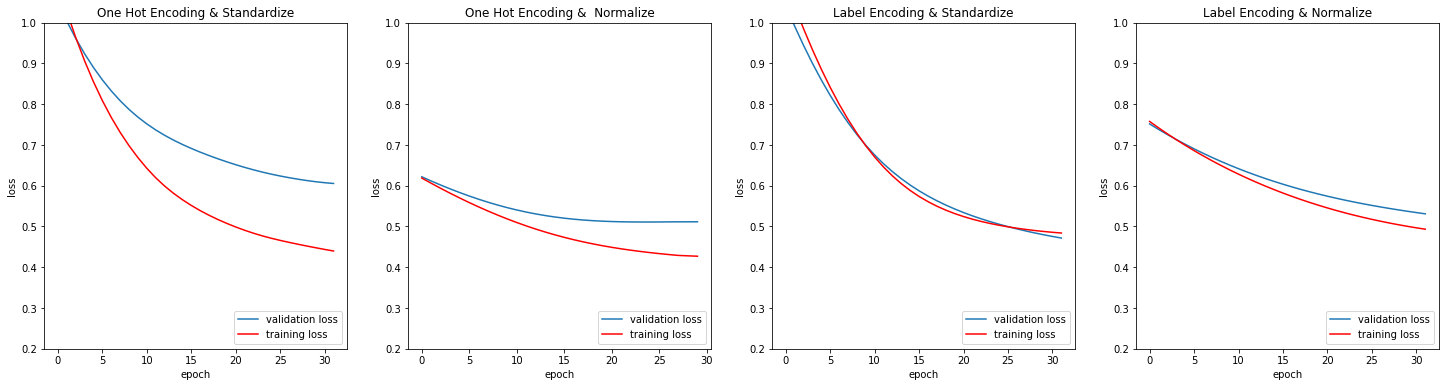

In [ ]:

fig = plt.figure(figsize=(25, 6));
for i,history in enumerate(histories):
  ax = fig.add_subplot(1, 4, i+1);
  ax.set_ylim((0.2,1.))
  ax.set_title(title_list[i])
  ax.set_xlabel("epoch")
  ax.set_ylabel("loss")
  ax.plot(history.history["val_loss"], label = "validation loss")
  ax.plot(history.history["loss"], color="red", label = "training loss")
  ax.legend(loc = 'lower right')
  print("{:<30}: {}".format(title_list[i], history.history["val_loss"][-1]))


#### Testing data

##### Accuracy And Loss

In [ ]:
pred_y_list = []
for i, model, trans, df in zip(range(len(model_list)), model_list, data_fits, test_dfs):
  x_test = trans.transform_features(df) 
  y_test = trans.transform_labels(df)
  pred_y = (model.predict(x_test) >0.5).astype("uint8")
  pred_y_list.append(pred_y)
  print("{:<30}, accuracy: {}, loss: {}".format(title_list[i], accuracy_score(pred_y, y_test), log_loss(pred_y, y_test)))

One Hot Encoding & Standardize, accuracy: 0.9473684210526315, loss: 1.8178494656993718
One Hot Encoding &  Normalize , accuracy: 0.9617224880382775, loss: 1.3220622524244778
Label Encoding & Standardize  , accuracy: 0.9354066985645934, loss: 2.2309812465366257
Label Encoding & Normalize    , accuracy: 0.9976076555023924, loss: 0.08263056457497918


##### ROC

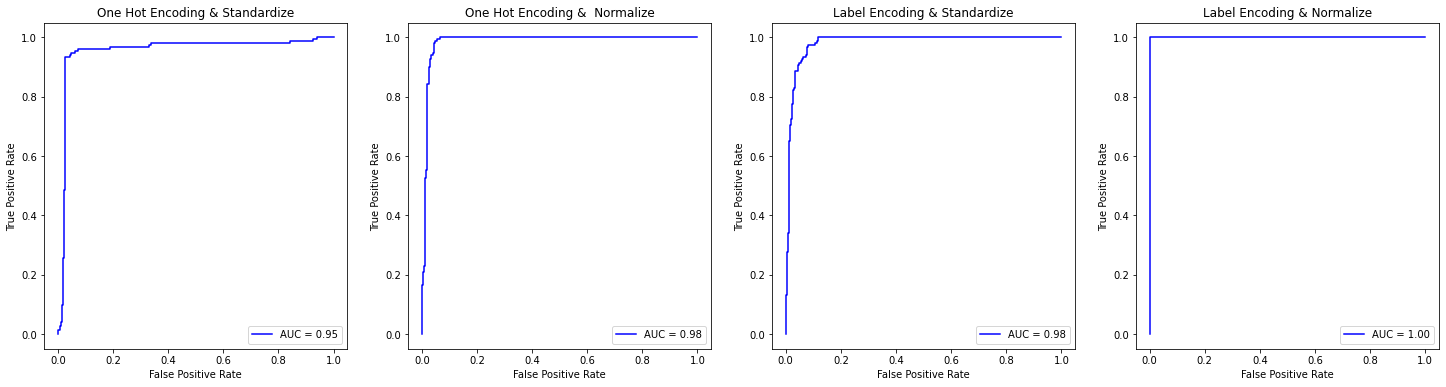

In [ ]:
fig = plt.figure(figsize=(25, 6));

for i, model, trans, df in zip(range(len(model_list)), model_list, data_fits, test_dfs):
  x_test = trans.transform_features(df) 
  y_test = trans.transform_labels(df)
  ax = fig.add_subplot(1, 4, i+1);
  ax.set_title(title_list[i])
  ax.set_xlabel("False Positive Rate")
  ax.set_ylabel("True Positive Rate")
  fpr, tpr, roc_auc = get_roc_auc(model, x_test, y_test)
  ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  ax.legend(loc = 'lower right')


##### Confusion matrix

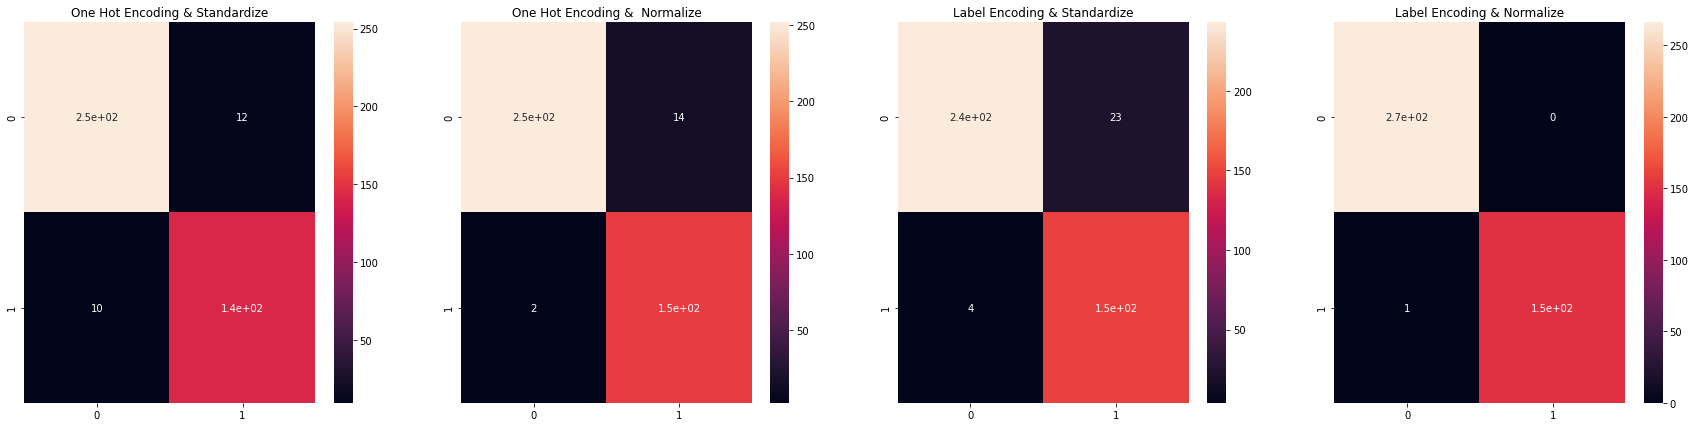

In [ ]:

fig = plt.figure(figsize = (30,7))

for i, model, trans, df in zip(range(len(model_list)), model_list, data_fits, test_dfs):
  x_test = trans.transform_features(df) 
  y_test = trans.transform_labels(df)
  ax = fig.add_subplot(1, 4, i+1);
  ax.set_title(title_list[i])
  sns.heatmap(get_confusion_matrix(model, x_test, y_test), annot=True, ax=ax)



### LogisticRegression

##### Training models

In [ ]:
sk_grid_list = []
param_grid = {
    "penalty":["l1","l2"],
    "C":[1e-4, 1e-2, 1e-1, 1],
    "solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "max_iter":[1000]
}
def run_grid_search():
  for i, trans, df in zip(range(len(data_fits)), data_fits, train_dfs):
    x_train = trans.transform_features(df);
    y_train = trans.transform_labels(df).to_numpy();
    y_train = y_train.reshape((len(y_train)))
    grid = GridSearchCV(estimator=LogisticRegression(),
      param_grid=param_grid,
      scoring='accuracy',
      cv=3)
    grid.fit(x_train, y_train)
    sk_grid_list.append(grid)

Thread(target = run_grid_search).start();


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_

In [ ]:


sk_model_list = []

def run_logistic_model():
  for i, trans, df, grid in zip(range(len(data_fits)), data_fits, train_dfs, sk_grid_list):
    x_train = trans.transform_features(df);
    y_train = trans.transform_labels(df).to_numpy();
    y_train = y_train.reshape((len(y_train)))
    model = LogisticRegression(**grid.best_params_)
    model.fit(x_train, y_train)
    sk_model_list.append(model)

Thread(target = run_logistic_model).start();


##### Accuracy And Loss

In [ ]:
pred_y_list = []
for i, model, trans, df in zip(range(len(sk_model_list)), sk_model_list, data_fits, test_dfs):
  x_test = trans.transform_features(df) 
  y_test = trans.transform_labels(df)
  pred_y = (model.predict(x_test) >0.5).astype("uint8")
  pred_y_list.append(pred_y)
  print("{:<30}, accuracy: {}, loss: {}".format(title_list[i], accuracy_score(pred_y, y_test), log_loss(pred_y, y_test)))

One Hot Encoding & Standardize, accuracy: 0.8660287081339713, loss: 4.627263793385969
One Hot Encoding &  Normalize , accuracy: 0.9114832535885168, loss: 3.0572811535488698
Label Encoding & Standardize  , accuracy: 0.9425837320574163, loss: 1.9831086819368153
Label Encoding & Normalize    , accuracy: 0.9138755980861244, loss: 2.9747003246992154


##### ROC

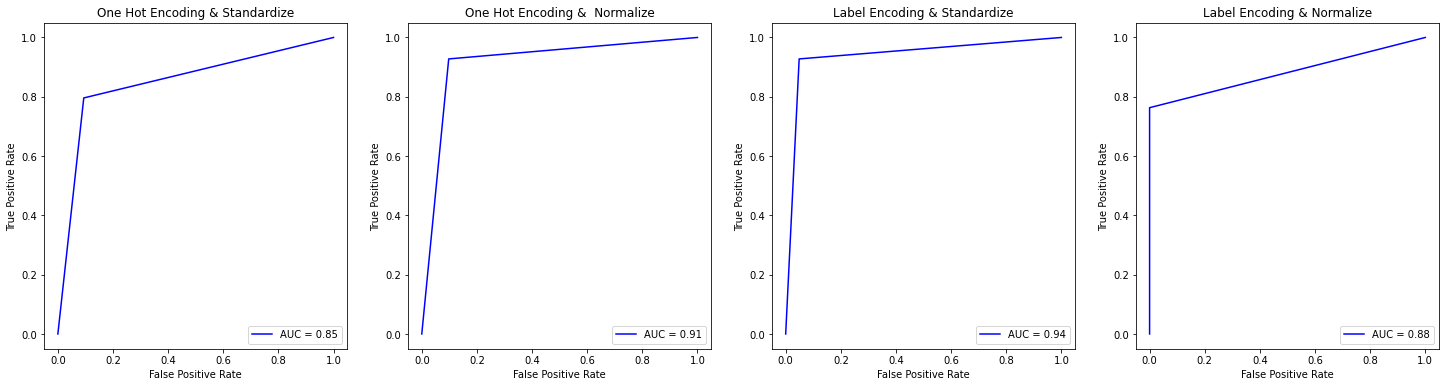

In [ ]:
fig = plt.figure(figsize=(25, 6));

for i, model, trans, df in zip(range(len(sk_model_list)), sk_model_list, data_fits, test_dfs):
  x_test = trans.transform_features(df) 
  y_test = trans.transform_labels(df)
  ax = fig.add_subplot(1, 4, i+1);
  ax.set_title(title_list[i])
  ax.set_xlabel("False Positive Rate")
  ax.set_ylabel("True Positive Rate")
  fpr, tpr, roc_auc = get_roc_auc(model, x_test, y_test)
  ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  ax.legend(loc = 'lower right')


##### Confusion matrix

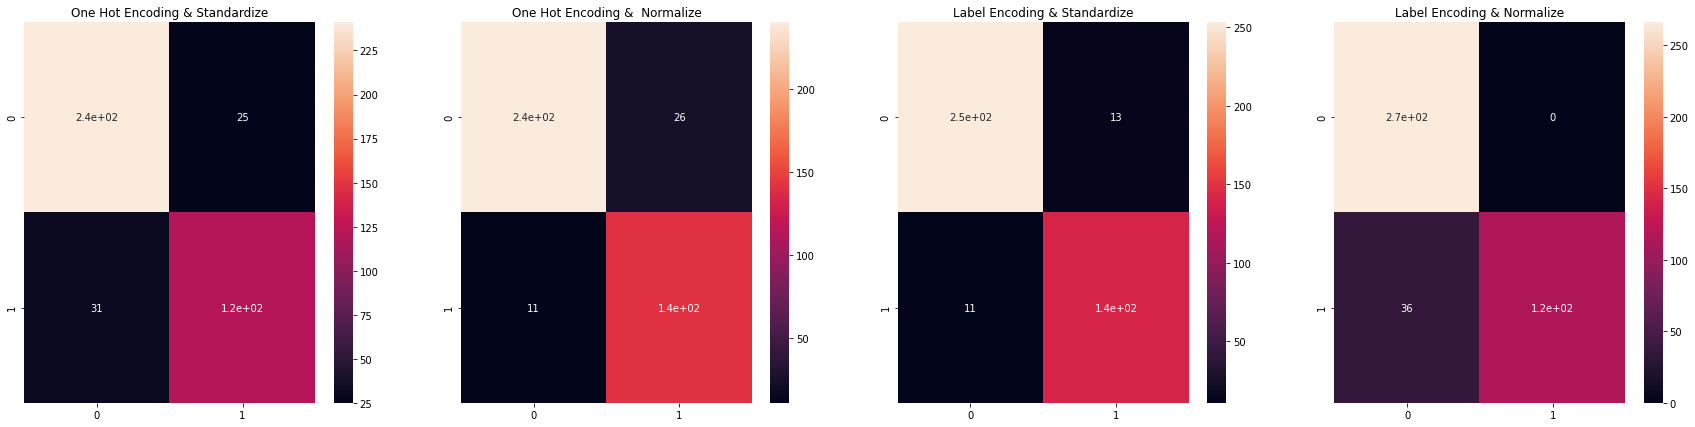

In [ ]:

fig = plt.figure(figsize = (30,7))

for i, model, trans, df in zip(range(len(sk_model_list)), sk_model_list, data_fits, test_dfs):
  x_test = trans.transform_features(df) 
  y_test = trans.transform_labels(df)
  ax = fig.add_subplot(1, 4, i+1);
  ax.set_title(title_list[i])
  sns.heatmap(get_confusion_matrix(model, x_test, y_test), annot=True, ax=ax)



### Adaline

##### Training models

In [38]:
class Adaline(object):
    def __init__(self, eta = 0.01, n_iter = 1000, random_state = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
#        self.w_ = np.array([0,0.34, 0.54, 0.07, 0.035,0.082,0.26,0.17]).reshape((8,1))
        self.cost_ = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    def activation(self, X):
        #X = X.copy()
        #X[X>0.3] = 1
        return X
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, 0)

In [39]:

ada_model_list = []

def run_ada_model():
  for i, trans, df in zip(range(len(data_fits)), data_fits, train_dfs):
    x_train = trans.transform_features(df);
    y_train = trans.transform_labels(df).to_numpy();
    y_train = y_train.reshape((len(y_train)))
    model = Adaline(n_iter = 60, eta = 0.0001, random_state=23)
    model.fit(x_train,y_train)
    ada_model_list.append(model)


Thread(target = run_ada_model).start();


##### Cost

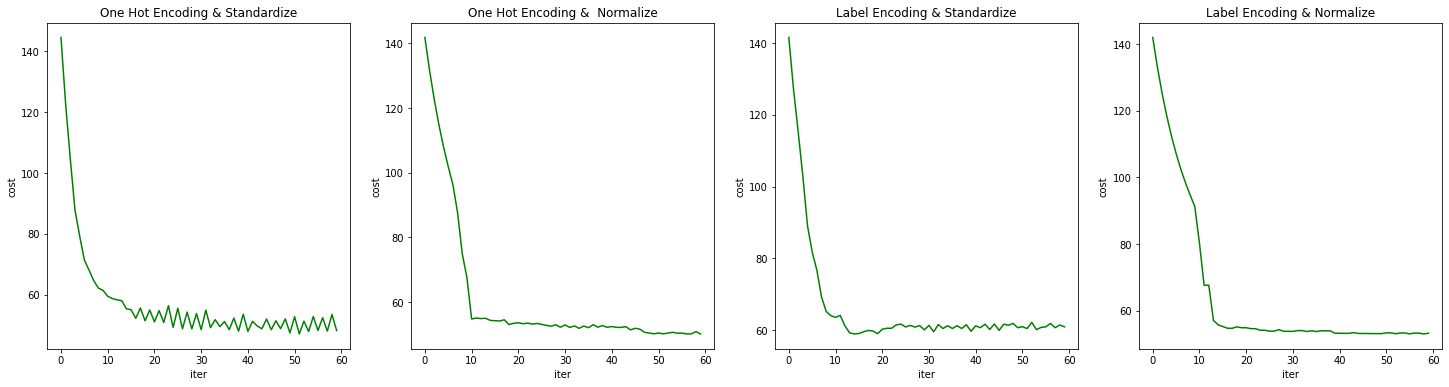

In [40]:
fig = plt.figure(figsize=(25, 6));
for i, model, trans, df in zip(range(len(ada_model_list)), ada_model_list, data_fits, test_dfs):
  ax = fig.add_subplot(1, 4, i+1);
  ax.set_title(title_list[i])
  ax.set_xlabel("iter")
  ax.set_ylabel("cost")
  ax.plot(model.cost_, 'g')

##### Accuracy And Loss

In [41]:
pred_y_list = []
for i, model, trans, df in zip(range(len(ada_model_list)), ada_model_list, data_fits, test_dfs):
  x_test = trans.transform_features(df) 
  y_test = trans.transform_labels(df).to_numpy()
  y_test = y_test.reshape((len(y_test)))
  pred_y = (model.predict(x_test) >0.5).astype("uint8")
  pred_y_list.append(pred_y)
  print("{:<30}, accuracy: {}, loss: {}".format(title_list[i], accuracy_score(y_test, pred_y), log_loss(y_test, pred_y)))

One Hot Encoding & Standardize, accuracy: 0.3803827751196172, loss: 21.40131622491935
One Hot Encoding &  Normalize , accuracy: 0.36363636363636365, loss: 21.97973017694419
Label Encoding & Standardize  , accuracy: 0.36363636363636365, loss: 21.97973017694419
Label Encoding & Normalize    , accuracy: 0.36363636363636365, loss: 21.97973017694419


##### ROC

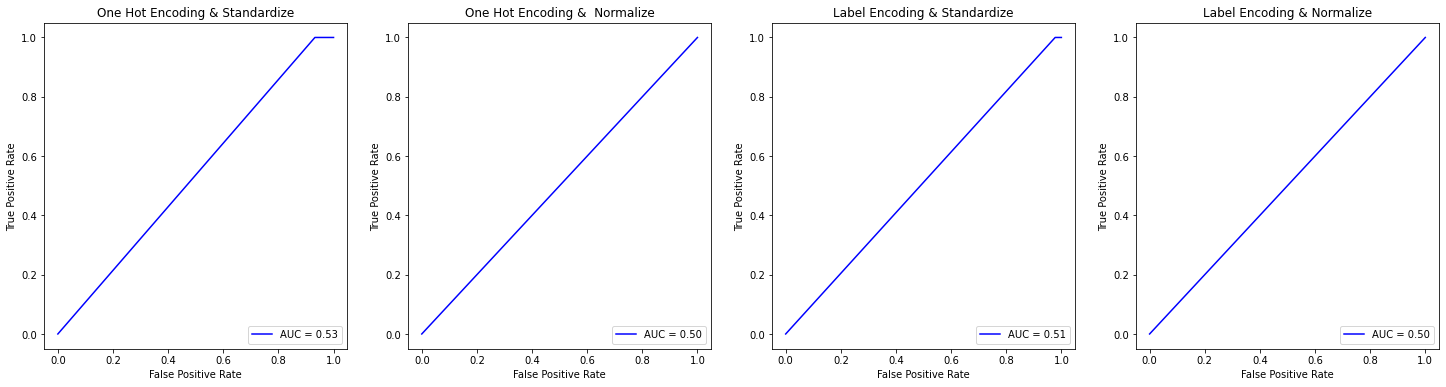

In [ ]:
fig = plt.figure(figsize=(25, 6));

for i, model, trans, df in zip(range(len(ada_model_list)), ada_model_list, data_fits, test_dfs):
  x_test = trans.transform_features(df) 
  y_test = trans.transform_labels(df).to_numpy()
  y_test = y_test.reshape((len(y_test)))
  ax = fig.add_subplot(1, 4, i+1);
  ax.set_title(title_list[i])
  ax.set_xlabel("False Positive Rate")
  ax.set_ylabel("True Positive Rate")
  fpr, tpr, roc_auc = get_roc_auc(model, x_test, y_test)
  ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  ax.legend(loc = 'lower right')


##### Confusion matrix

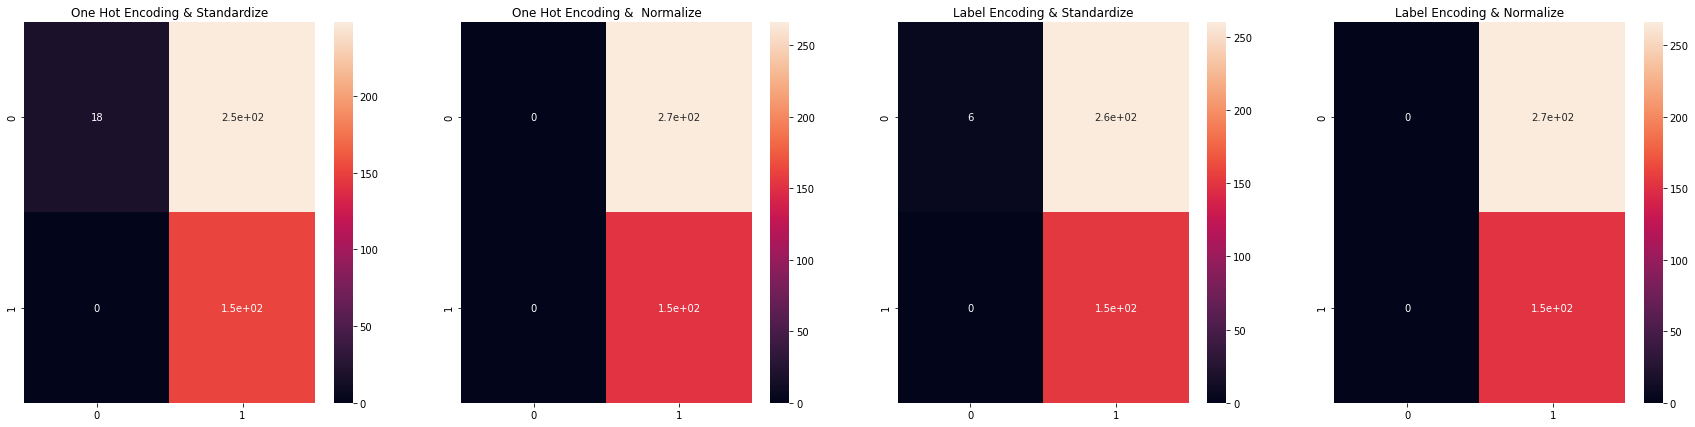

In [ ]:

fig = plt.figure(figsize = (30,7))

for i, model, trans, df in zip(range(len(ada_model_list)), ada_model_list, data_fits, test_dfs):
  x_test = trans.transform_features(df) 
  y_test = trans.transform_labels(df).to_numpy()
  y_test = y_test.reshape((len(y_test)))
  ax = fig.add_subplot(1, 4, i+1);
  ax.set_title(title_list[i])
  sns.heatmap(get_confusion_matrix(model, x_test, y_test), annot=True, ax=ax)



# End